# Inferencia Bayesiana

En las sesiones anteriores hemos tratado los contrastes de hipótesis como un medio para sacar conclusiones sobre las propiedades de una población. Como hemos visto, los contrastes de hipótesis se basan en el cálculo de un valor a partir de las muestras (estadístico de contraste) y cómo de probable es que dicho valor haya sido generado por una distribución teórica conocida bajo una hipóteis nula (p-valor). 

Sin embargo, el uso de los contrastes de hipótesis lleva asociado una serie de decisiones previas subjetivas que debe tomar el investigador:

1. Elegir el contraste/test adecuado.
2. Establecer la hipótesis alternativa.
3. Elegir la significación $(\alpha)$.

Estas decisiones previas suelen tomarse de manera subjetiva teniendo en cuenta estudios o experiencias anteriores.

Una aproximación más adecuada al problema de, por ejemplo, querer comparar las medias de dos poblaciones independientes, sería __estimar__ cuánto de diferentes son las medias poblaciones de los grupos, en lugar de realizar un test para detectar si los grupos son diferentes o no. 

La estimación de la diferencia de las medias poblacionales es mucho más informativa, y mediante __métodos de inferencia Bayesiana__ pueden darse, además, estimaciones sobre la incertidumbre asociada a la diferencia; en dicha incertidumbre se incluirían las incertidumbres debidas al desconocimento del modelo de los parámetros, así como la incertidumbre aleatoria del propio sistema que genera los datos.

# Modelando nuestras creencias: distribución previa (prior) y verosimilitud (likelihood)

Repasamos los conceptos sobre el Teorema de Bayes en el primer notebook: Introducción a la probabilidad. Vamos a simular una situación en la que queremos estimar el porcentaje de fallos de cierto servicio en una plataforma logística. El servicio puede fallar o no con cierta probabilidad, ¿cuál es __la creencia__ que tengo sobre ese posible fallo? A dicha creencia le asignamos un modelo probabilístico, llamando $\pi$ a la probabilidad de que el servicio falle.

In [1]:
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'
#pylab.rcParams['figure.figsize'] = (10, 6)
#plt.style.use('ggplot')

import pandas as pd
import scipy.stats as st
import seaborn as sns # Para dibujar distribuciones con poco código
sns.set(color_codes=True)

Populating the interactive namespace from numpy and matplotlib


Si no tengo ninguna creencia sobre cuál puede ser la probabilidad de fallo, el modelo que describe la distribución de $\pi$ será la distribución __Uniforme__ en el intervalo $(0,1)$, o lo que es lo mismo, la distribución __Beta__ con parámetros $(1,1)$: $\mathcal{B}eta (1,1)$

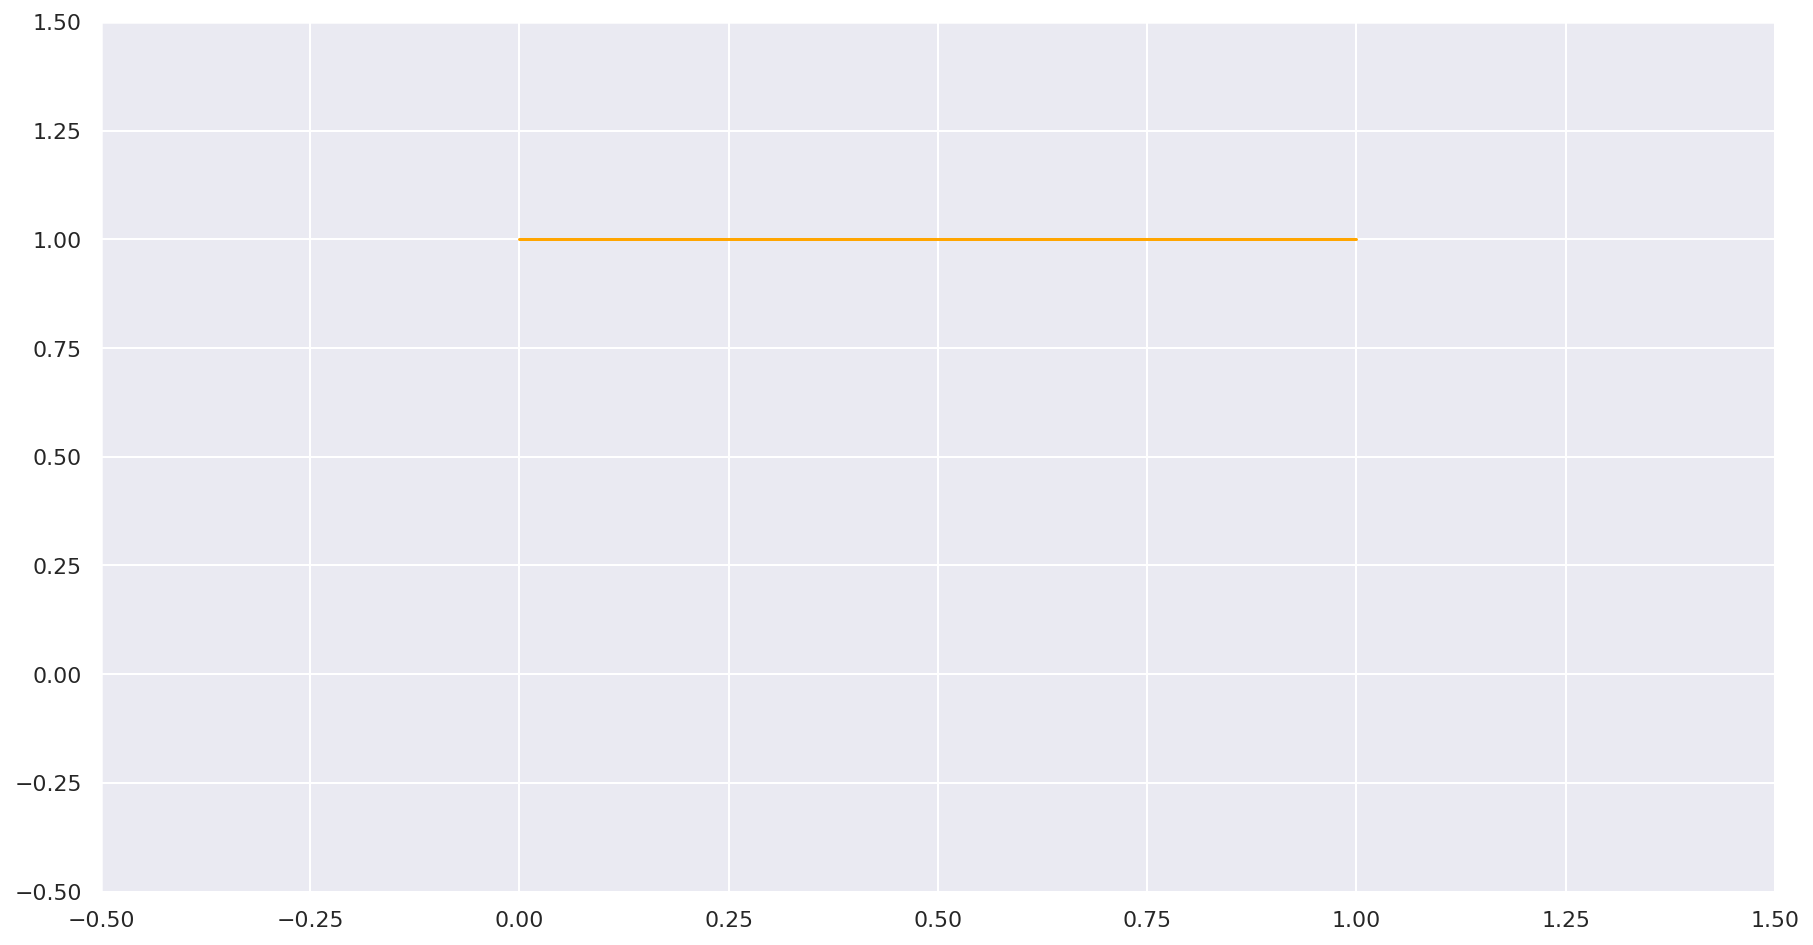

In [2]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
x = np.linspace(0.,1.,1000)
prior = st.beta(1., 1.).pdf(x)
ax.plot(x, prior, color='orange')
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.5, 1.5]);

Pero esta creencia podría cambiar y modelarla, por ejemplo, con una $\mathcal{B} (3, 10)$, es decir: 

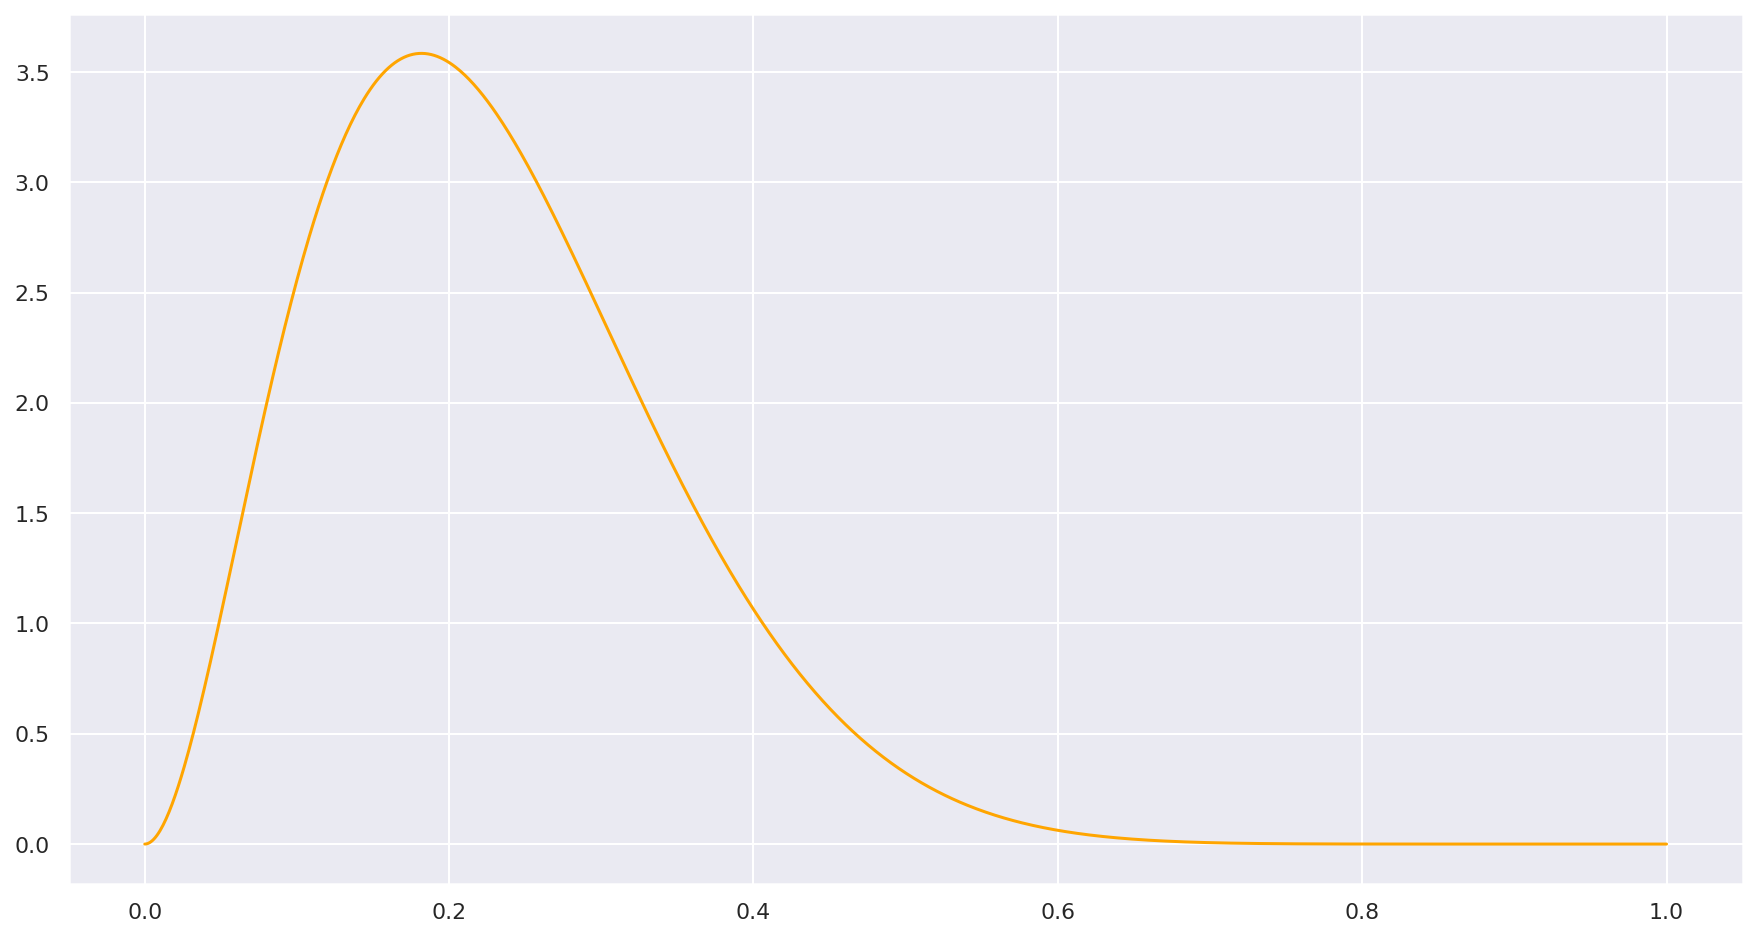

In [3]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
x = np.linspace(0.,1.,1000)
prior = st.beta(3., 10.).pdf(x)
ax.plot(x, prior, color='orange');

Ahora bien, una vez recogido los datos, el número de servicios que falla en esa plataforma logística, de los 10 que hay, se modela a partir de una distribución __Binomial__ con parámetros $\mathcal{B}i(\pi, 10)$. Si se hubieran producido 4 fallos, la función de __verosimilitud__ sería 

$$P(X=4 | \pi) = {10 \choose 4} \cdot \pi^4 \cdot (1-\pi)^{10-4}$$

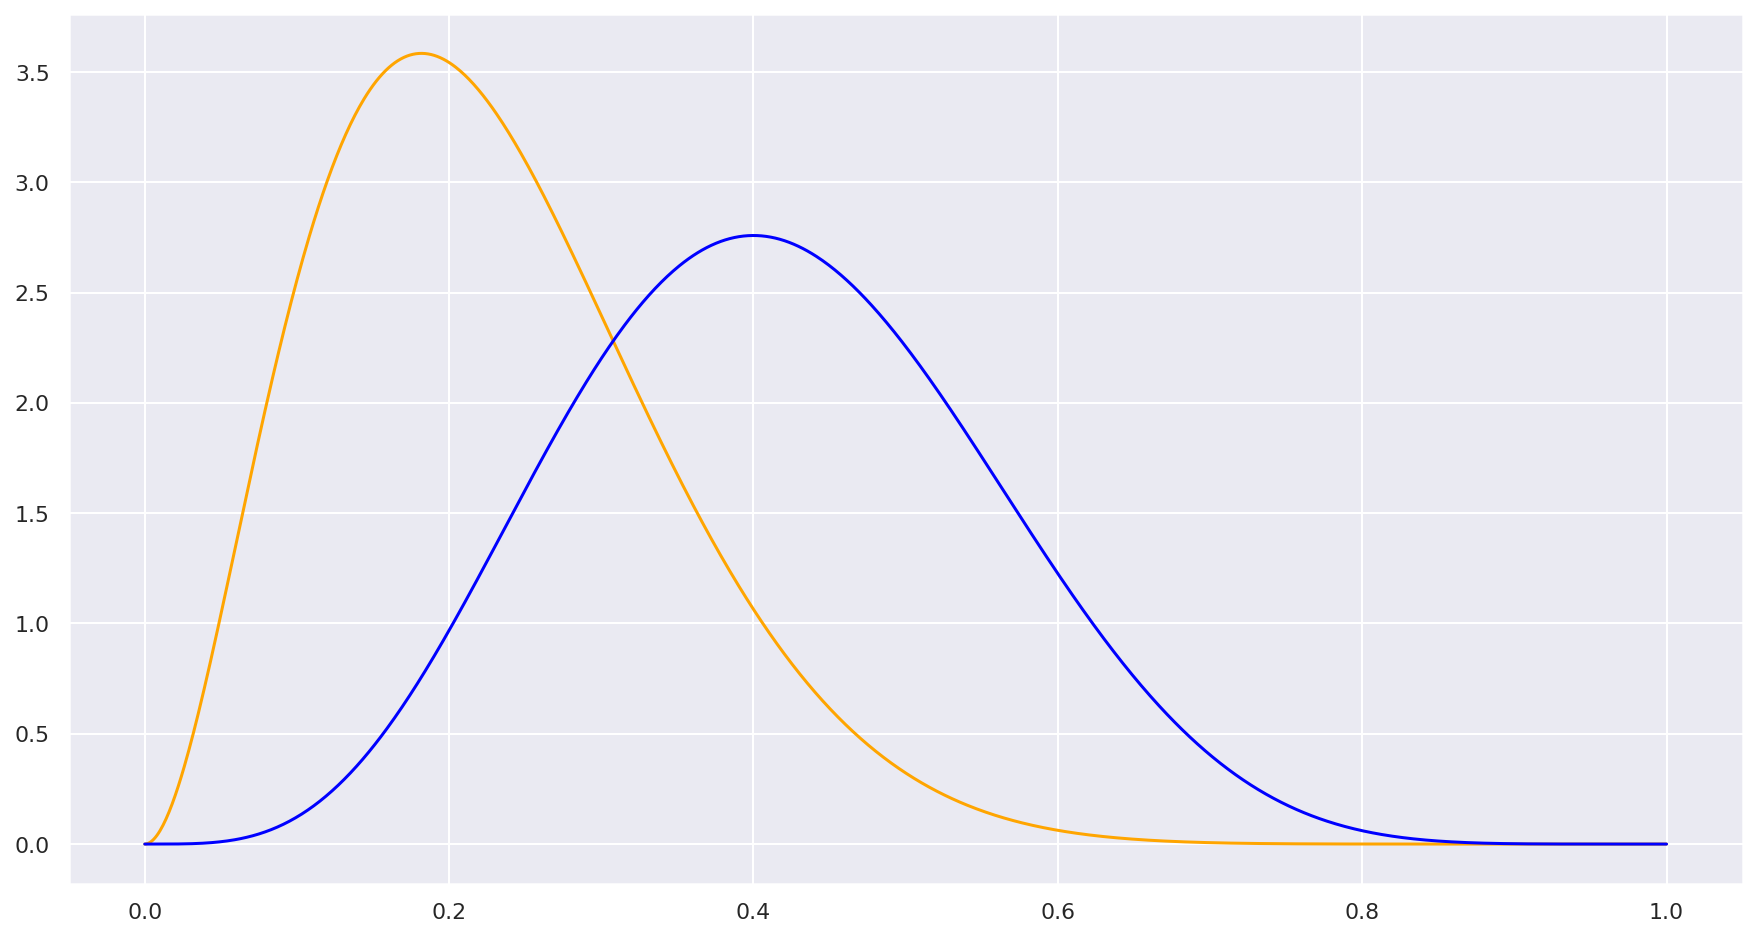

In [9]:
import scipy.special
import scipy.integrate

def likelihood_func(x, n=10, k=4):
    #cte = scipy.special.comb(n,k)
    like = st.binom(n, x).pmf(k)
    # y = cte * like
    return like

theta = np.linspace(0.,1.,1000)
likelihood = likelihood_func(x = theta, n=10, k=4)
evidence, abserr = scipy.integrate.quad(likelihood_func, a=0, b=1)
#print(evidence)

fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(x, prior, color='orange');
ax.plot(x, likelihood/evidence, color='blue');

Recordando el teorema de Bayes 

$$P(\pi | D) = \frac{P(D | \pi) \cdot P(\pi)}{P(D)} = \frac{P(D | \pi)}{P(D)} \cdot P(\pi)$$

En nuestro caso

$$P(\pi | D) = \frac{\mathcal{B}i (4; 10, \pi)}{P(D)} \cdot \mathcal{B}eta(3, 10)$$

En este caso, la distribución previa y la verosimilitud __son conjugadas__, es decir, su producto vuelve a ser de la misma familia que la distribución previa:

$$P(\pi | y) = \frac{ \mathcal{B}i(n,\pi)}{P(D)} \cdot \mathcal{B}eta (\alpha, \beta) = \mathcal{B}eta(y+\alpha, n-y+\beta)$$

En nuestro caso:

$$P(\pi | D) = \mathcal{B}eta (4 + 3, 10-4+10) = \mathcal{B}eta (7, 16)$$

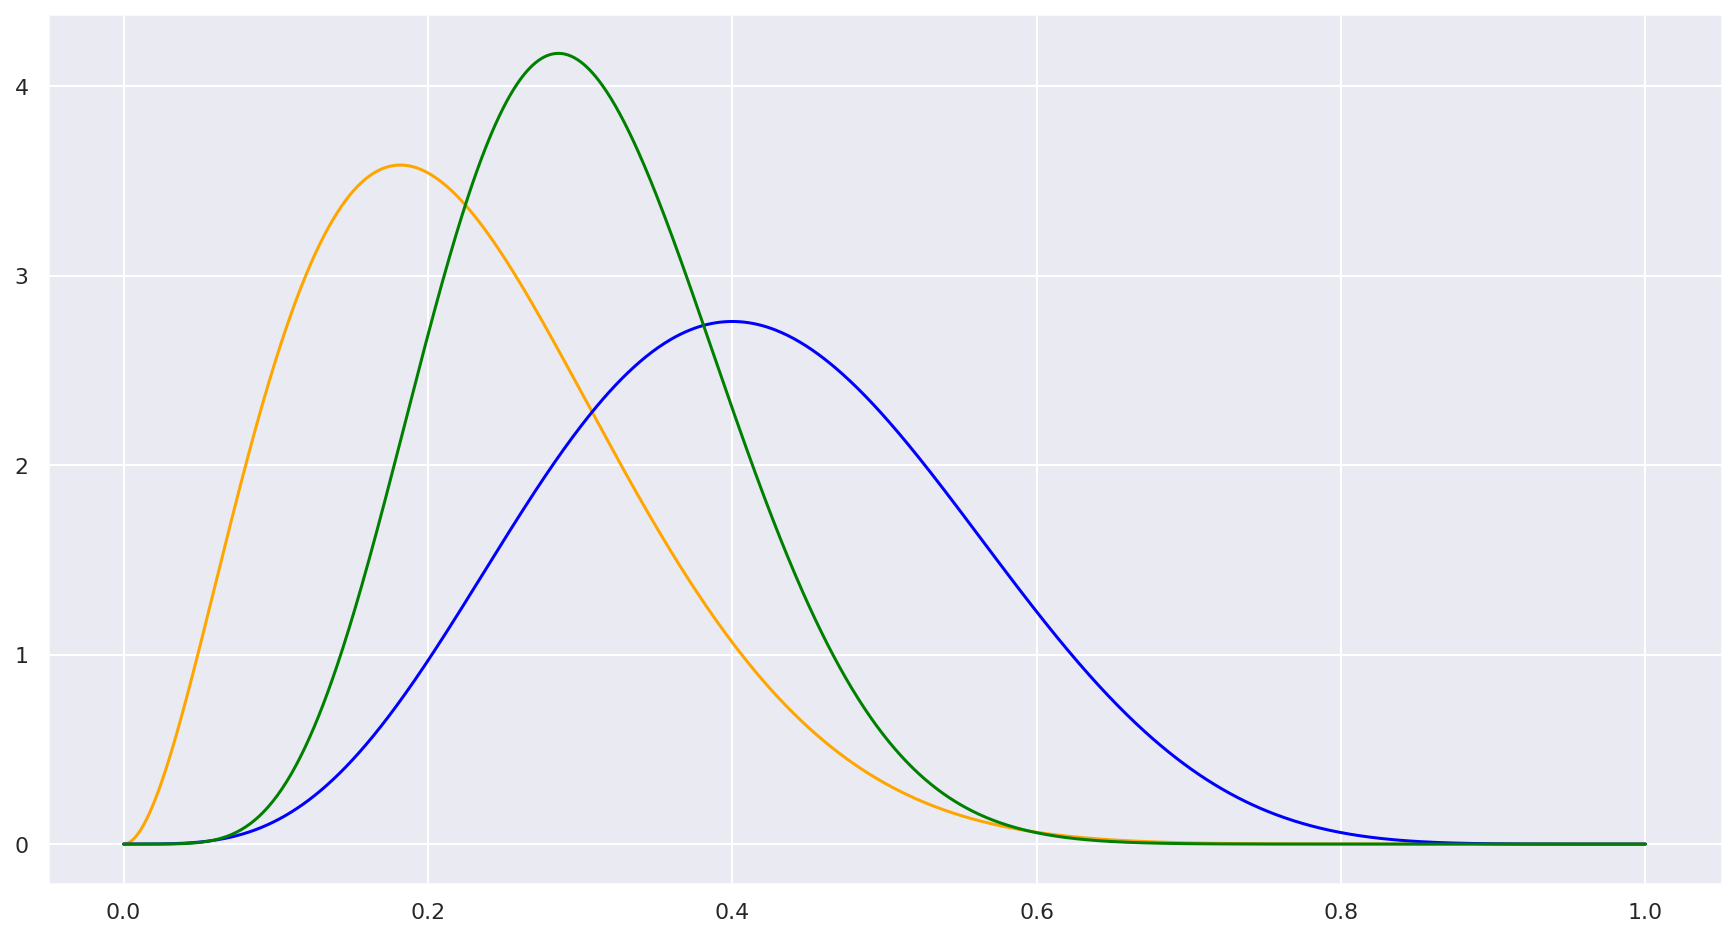

In [10]:
posterior = st.beta(7., 16.).pdf(x)

fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(x, prior, color='orange');
ax.plot(x, likelihood/evidence, color='blue');
ax.plot(x, posterior, color='green');

__Ejercicio__ Juega con la distribución previa y con la verosimilitud:

1. ¿Cómo influye en la distribución posterior el hecho de que pongamos una distribución previa NO informativa (uniforme)?

2. Dejando fija una distribución previa, ¿cómo influye en la distribución posterior le hecho de que el tamaño muestral aumente?

## ¿Y si no tuviéramos la posibilidad de utilizar distribuciones conjugadas?

En ese caso tendremos que representar la distribución posterior como un conjunto de muestras a partir de la relación

$$P(\pi | D) = \frac{P(D | \pi) \cdot P(\pi)}{P(D)} = \frac{P(D | \pi)}{P(D)} \cdot P(\pi) \propto P(D | \pi) \cdot P(\pi)$$

Para generar muestras de la distribución posterior existen muchas herramientas.

In [11]:
import pymc3 as pm  # http://docs.pymc.io/index.html
print('Ejecutando PyMC3 v{}'.format(pm.__version__))

Ejecutando PyMC3 v3.8


In [12]:
# help(pm.Beta)

Definimos el modelo que necesitamos para obtener muestras de la distribución posterior

In [13]:
with pm.Model() as model:

    # Distribución a priori
    pi = pm.Beta('pi', alpha=3, beta=10)
    
    # Verosimilitud de las observaciones
    obs = pm.Binomial('obs', n=10, p=pi, observed=4)

Utilizamos algoritmo __Metropolis-Hastings__ para obtener las muestras de la distribución posterior utilizando conjuntamente una __Cadena de Markov__ y el método de __Monte Carlo__ (MCMC: Markov Chain Monte Carlo). De manera muy simple

1. __Monte Carlo__: Métodos para generar muestras para obtener un resultado numérico (ver imagen más abajo).

$$\theta_t \sim \mathcal{N}(0.5, 0.1)$$

2. __Cadena de Markov__: Es una secuencia de números en el que cada número ha salido del anterior a partir de una distribución propuesta:

$$ \theta_t \sim \mathcal{N} (\theta_{t-1} , 0.1) $$

3. __Metropolis-Hastings__: Es un algoritmo con el que decidimos que $\theta_t$ propuesto por la cadena de Markov es aceptado o rechazado. Calculamos

$$r(\theta_{new}, \theta_{t-1}) = \frac{Beta(\theta_{new};3,10) \cdot Binomial(4; \theta_{new}, 10)}{
Beta(\theta_{t-1};3,10) \cdot Binomial(4; \theta_{t-1}, 10)}$$

Si $r(\theta_{new}, \theta_{t-1}) > 1$ aceptamos $\theta_{new}$.

Si $r(\theta_{new}, \theta_{t-1}) < 1$, generamos un número aletorio, u, entre 0 y 1. Si $u < r(\theta_{new}, \theta_{t-1})$ entonces aceptamos $\theta_{new}$, en caso contrario no lo aceptamos, y $\theta_{new} = \theta_{t-1}$.

In [14]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [pi]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 2065.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


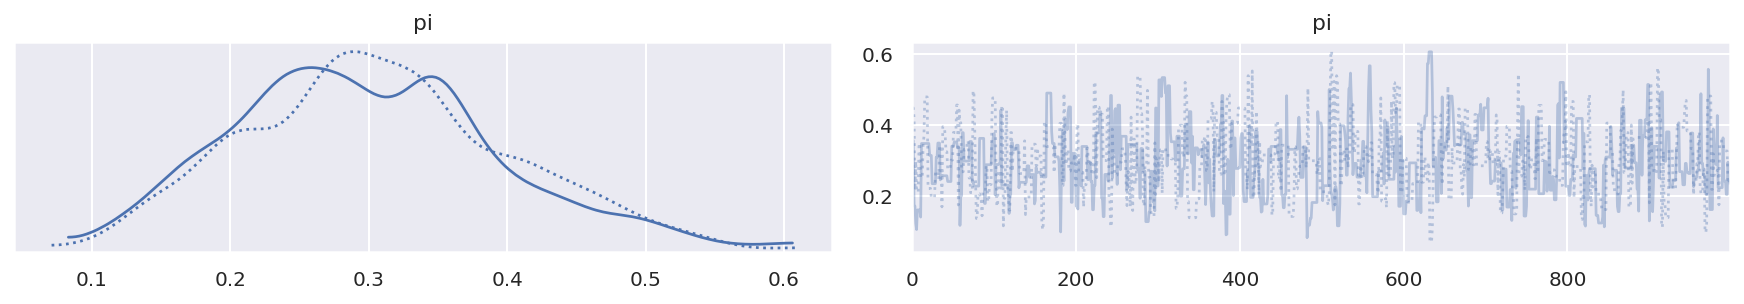

In [15]:
pm.traceplot(trace, var_names=['pi']);

In [16]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
pi,0.303,0.096,0.139,0.49,0.005,0.003,446.0,439.0,450.0,483.0,1.0


El método tiene varios problemas:

1. Elegir la distribución que propone las muestras. 
2. El punto inicial donde comienza a generarse la cadena. 
3. La autocorrelación entre las muestras.

Si la cadena ha convergido (traceplot estable), podemos mitigar el efecto del punto 2, eliminando algunos elementos del principio de la cadena (burn-in). Con pymc3 esto se realiza con skip_first __(en la nueva versión hay utilizar los parámetros__ `draws` __y__ `tune` __)__

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [pi]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:02<00:00, 1978.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


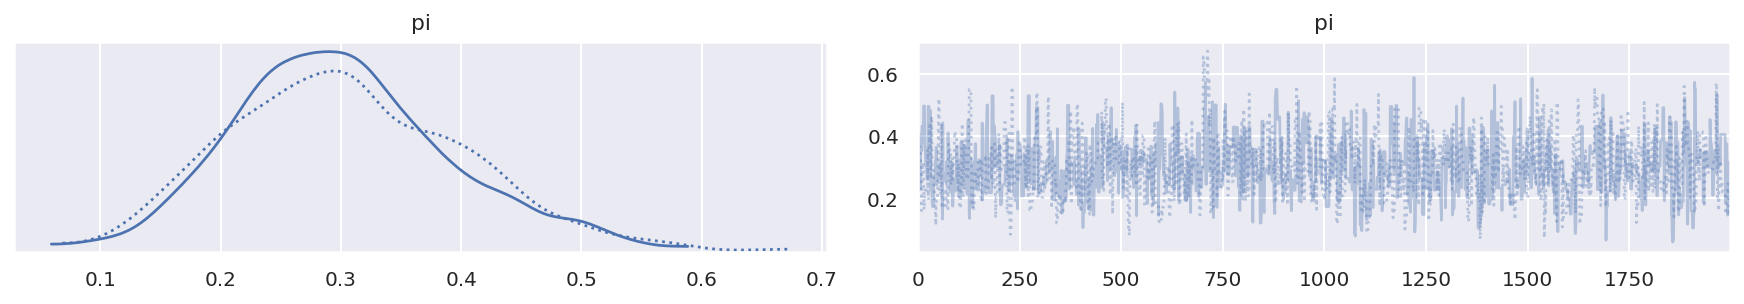

In [17]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(draws=2000, tune=500, step=step, chains=2)

pm.traceplot(trace, var_names=['pi']);

Utilizamos otro modo de extraer muestras de la distribución posterior

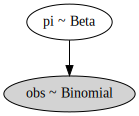

In [18]:
with pm.Model() as model:

    # Distribución a priori
    pi = pm.Beta('pi', alpha=3, beta=10)
    
    # Verosimilitud de las observaciones
    obs = pm.Binomial('obs', n=10, p=pi, observed=4)

    
    
pm.model_to_graphviz(model)

In [19]:
with model:
    model_trace = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pi]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 770.97draws/s]


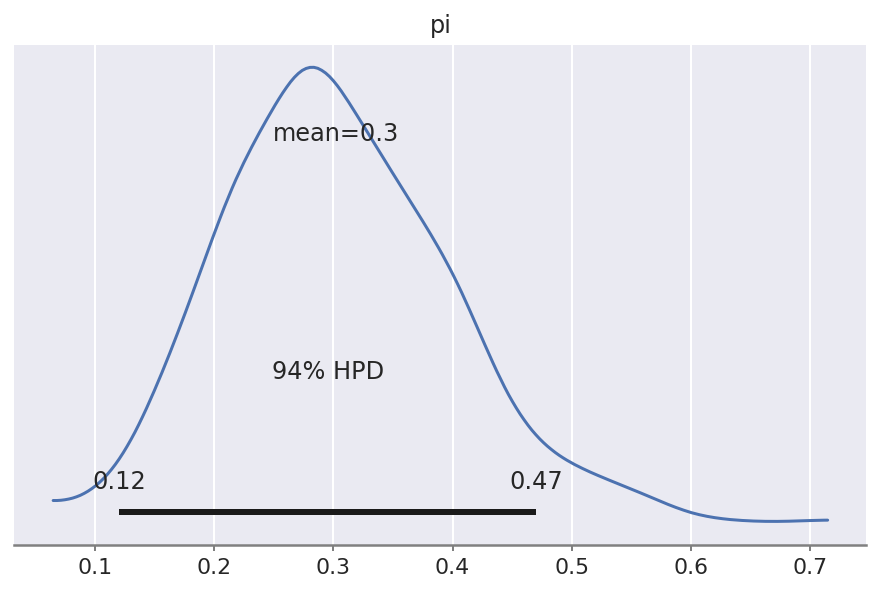

In [21]:
pm.plot_posterior(model_trace, var_names=['pi']);

__Ejercicio__ Realiza de nuevo el ejercicio a partir de simulaciones con una distribución Bernoulli:

```python
pi_verdadero = 0.36
muestras = st.bernoulli(pi_verdadero).rvs(10)
print(muestras)
```

In [27]:
pi_verdadero = 0.36
muestras = st.bernoulli(pi_verdadero).rvs(10)
print(muestras)

muestras = st.binom(p=pi_verdadero, n=10).rvs(10)
print(muestras)

with pm.Model() as model:
    # Distribución a priori
    pi = pm.Beta('pi', alpha=3, beta=10)

    # Verosimilitud de las observaciones
    obs = pm.Binomial('obs', n=10, p=pi, observed=muestras)

    
with model:
     model_trace = pm.sample(draws=1000, tune=1000)

[1 0 0 0 0 0 1 1 0 1]
[2 3 3 3 5 3 1 1 6 3]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pi]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 699.23draws/s]
The acceptance probability does not match the target. It is 0.880039768173467, but should be close to 0.8. Try to increase the number of tuning steps.


In [28]:
# pm.plot_posterior(model_trace, var_names=['pi']);

## Sustituyendo el contraste para dos poblaciones independientes por la inferencia Bayesiana

In [29]:
Y1 = st.norm(loc=7500, scale=1000)
Y2 = st.norm(loc=8000, scale=1000)

sueldos_hombres = Y1.rvs(500)  # Tamaño muestral 500
sueldos_mujeres = Y2.rvs(300)  # Tamaño muestral 300

st.ttest_ind(sueldos_hombres, sueldos_mujeres, equal_var = True)

Ttest_indResult(statistic=-7.425514568342703, pvalue=2.887084152169557e-13)

Vamos a crear un DataFrame con los datos generados:

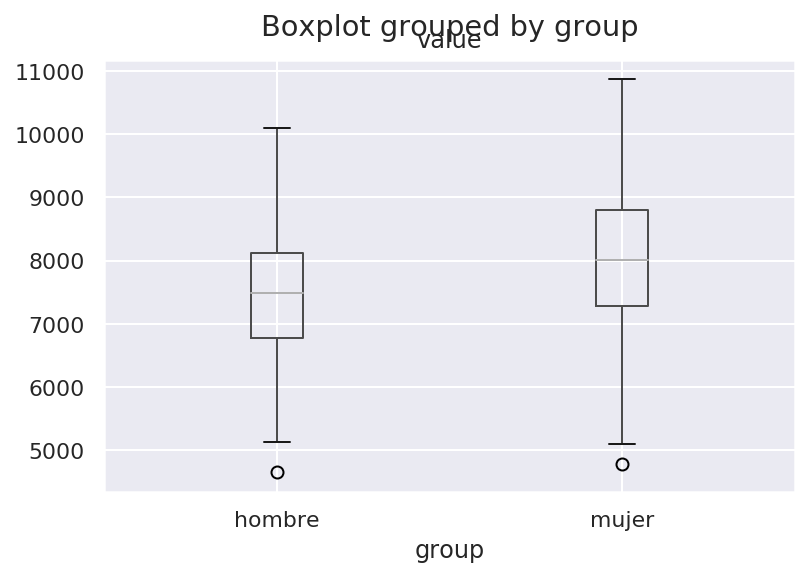

In [30]:
y1 = sueldos_hombres
y2 = sueldos_mujeres
y = pd.DataFrame(dict(value=np.r_[sueldos_hombres, sueldos_mujeres],
                      group=np.r_[['hombre']*len(sueldos_hombres), ['mujer']*len(sueldos_mujeres)]))

y.boxplot('value', by='group');

### Paso 1: Definimos el modelo probabilístico a priori

El primer paso consiste en definir un modelo probabilísco completo para el problema en cuestión. De las observaciones podemos deducir que una buena distribución para modelar los datos es la ditribución t-Student, ya que se ajusta bien cuando existen datos atípicos tal y como se muestran en los diagramas de caja, es decir, 

$$X_1 \sim t(\nu, \mu_1, \sigma_1), \qquad X_2 \sim t(\nu, \mu_2, \sigma_2)$$

Observemos que hemos elegido una distribución t-Student general, es decir, con función de densidad

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$

la cual tiene tres parámetros: $\nu, \, \mu, \, \sigma$.

En nuestro ejemplo, y por motivos de simplificación, vamos a suponer que las dos distribuciones con las que modelamos los datos tienen el mismo parámetro $\nu$, pero distintos $\mu_i$ y $\sigma_i$.

Sin embargo, __no sabemos nada__ sobre los parámetros $\nu$, $\mu_i$ y $\sigma_i$ para $i=1,2$, es decir, a priori tenemos incertidumbre de qué valores tomarán dichos parámetros en nuestro modelo, pero esa incertidumbre la podemos medir con un nuevo modelo probabilístico.

Como las medias son valores reales, podemos modelarlas a través de una distribución normal, y fijar los parámetros de dichas distribuciones normales (hiperparámetros) de la siguiente manera: las medias con las medias muestrales de la muestra, y como desviaciones típicas dos veces la desviaciónes típicas muestrales. De esta manera otorgamos a estas cantidades una información difusa, lo que significa que no hay predilección clara por ningún valor concreto:

$$\mu_i \sim N(\bar{x}, 2s)$$

In [31]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)

Para las desviaciones típicas $\sigma_i$ utilizaremos una distribución uniforme que contenga los valores plausibles en el rango de la variabilidad de las respuesta del IC. 

__[Pregunta]__ ¿Por qué no hacer variar en un rango más amplio? Debemos tener en cuenta las restricciones físicas de las variables que estemos midiendo. No tiene sentido ampliar los espacios parámetricos. 

In [32]:
σ_low = 1
σ_high = 2000

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

Finalmente, utilizamos como distribución a priori (previa) de $\mu$ una distribución exponencial de media 30. Esto posibilita obtener distribuciones que van desde la distribución normal (valores de $\nu$ grandes) hasta distribuciones con colas pesadas para incluir valores atípicos (valores de $\nu$ pequeños)

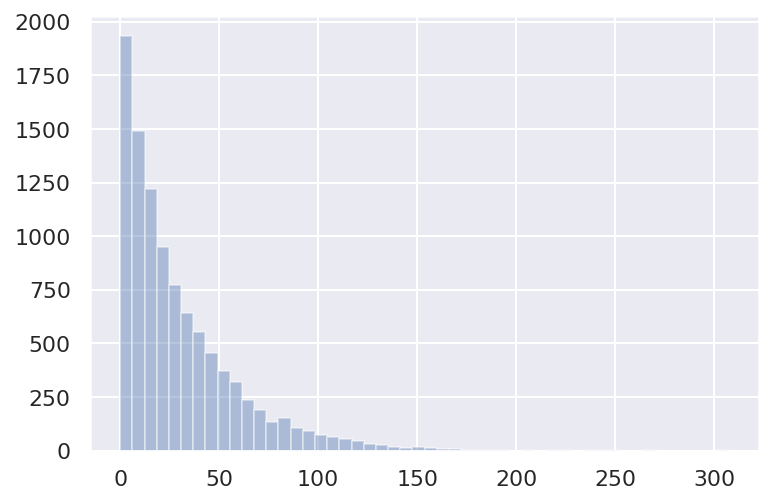

In [33]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

sns.distplot(np.random.exponential(30, size=10000), kde=False);

Puesto que PyMC3 parametriza la distribución t-Student en términos de precisión, en lugar de la desviación estándar, transformamos las desviaciones antes de definir las __verosimilitudes__

In [34]:
with model:
    λ1 = group1_std**(-2)
    λ2 = group2_std**(-2)
    group1 = pm.StudentT('hombre', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('mujer', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

Ya está definido completamente el modelo probabilístico. Ahora podemos generar cantidades de nuestro interés, como por ejemplo __la diferencia de medias__ o __la diferencia entre las desviaciones típicas__. También incluiremos __el tamaño del efecto__ a través de la $d$ de Cohen, es decir,  una diferencia de medias estandarizada. O dicho de otro modo, una medida de cuántas desviaciones típicas de diferencia hay entre los resultados de los dos grupos que se comparan (grupo experimental y grupo de control).

In [35]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

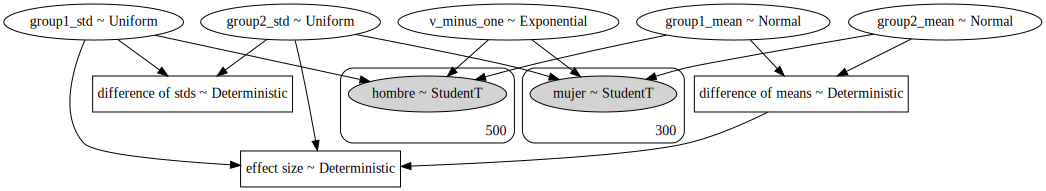

In [37]:
pm.model_to_graphviz(model)

### Paso 2: Actualizamos el modelo a partir de las observaciones

Actualizamos el modelo para conseguir la distribución posterior aplicando el teorema de bayes y técnicas basadas en cadenas de Markov con métodos de Monte Carlo (MCMC): 

$$P(\theta | y ) = \frac{P(y | \theta) \cdot P(\theta) }{ P(y) } = \frac{P(y | \theta) \cdot P(\theta)}{ \int P(y | \theta) \cdot P(\theta) \, \mbox{d}\theta} \propto P(y | \theta) \cdot P(\theta)$$

In [38]:
with model:
    trace = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:15<00:00, 395.55draws/s]


Podemos ver alguna de las cadenas de Markov calculadas

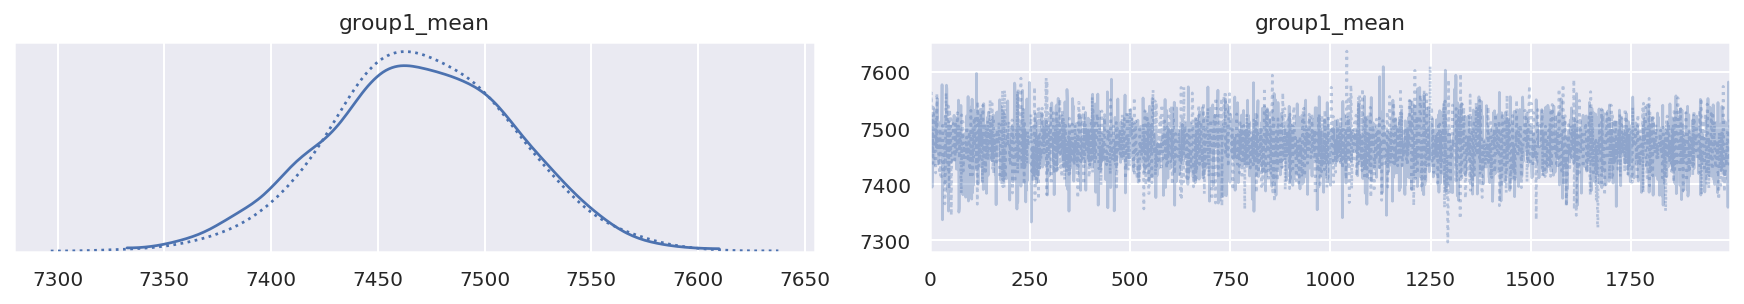

In [39]:
# pm.traceplot(trace)

pm.traceplot(trace, var_names=['group1_mean']);

Podemos pintar ahora las distribución posterior de los parámetros.

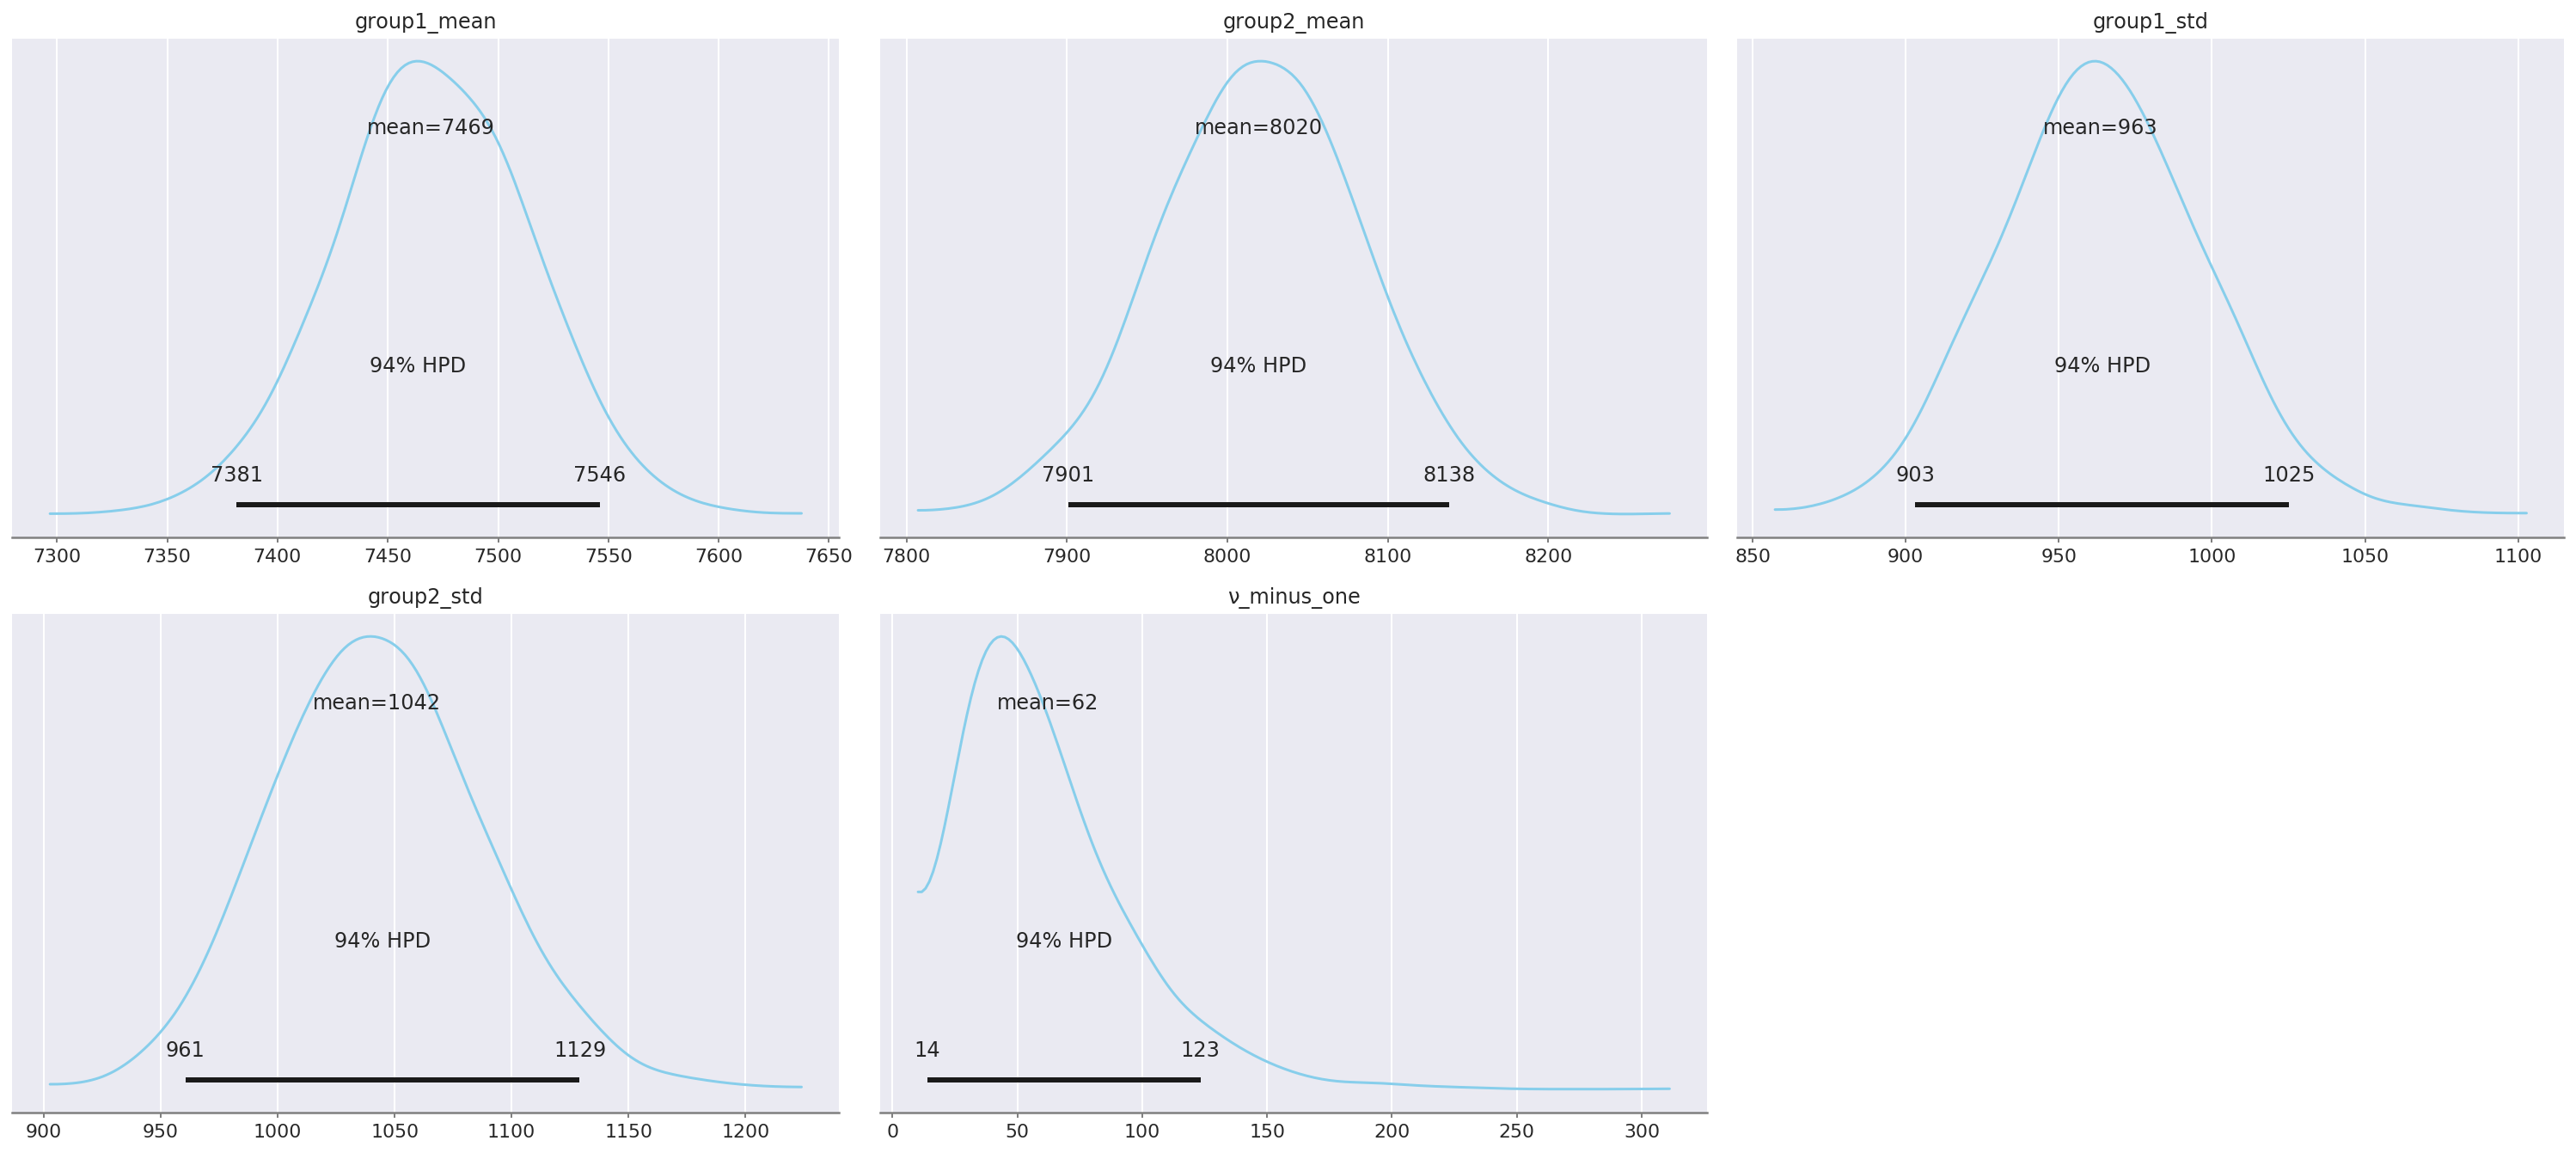

In [40]:
pm.plot_posterior(trace,
                  var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');


En cuanto a las cantidades generadas a partir de los parámetros, se puede concluir que existe diferencias significativas de los dos grupos para las tres cantidades calculadas. Es plausible, por tanto que 

$$ \mu_1 - \mu_2 > 0, \qquad \sigma_1 - \sigma_2 >0 $$


Estas estimaciones sugieren que el medicamento incrementa los valores IC esperados (en media).

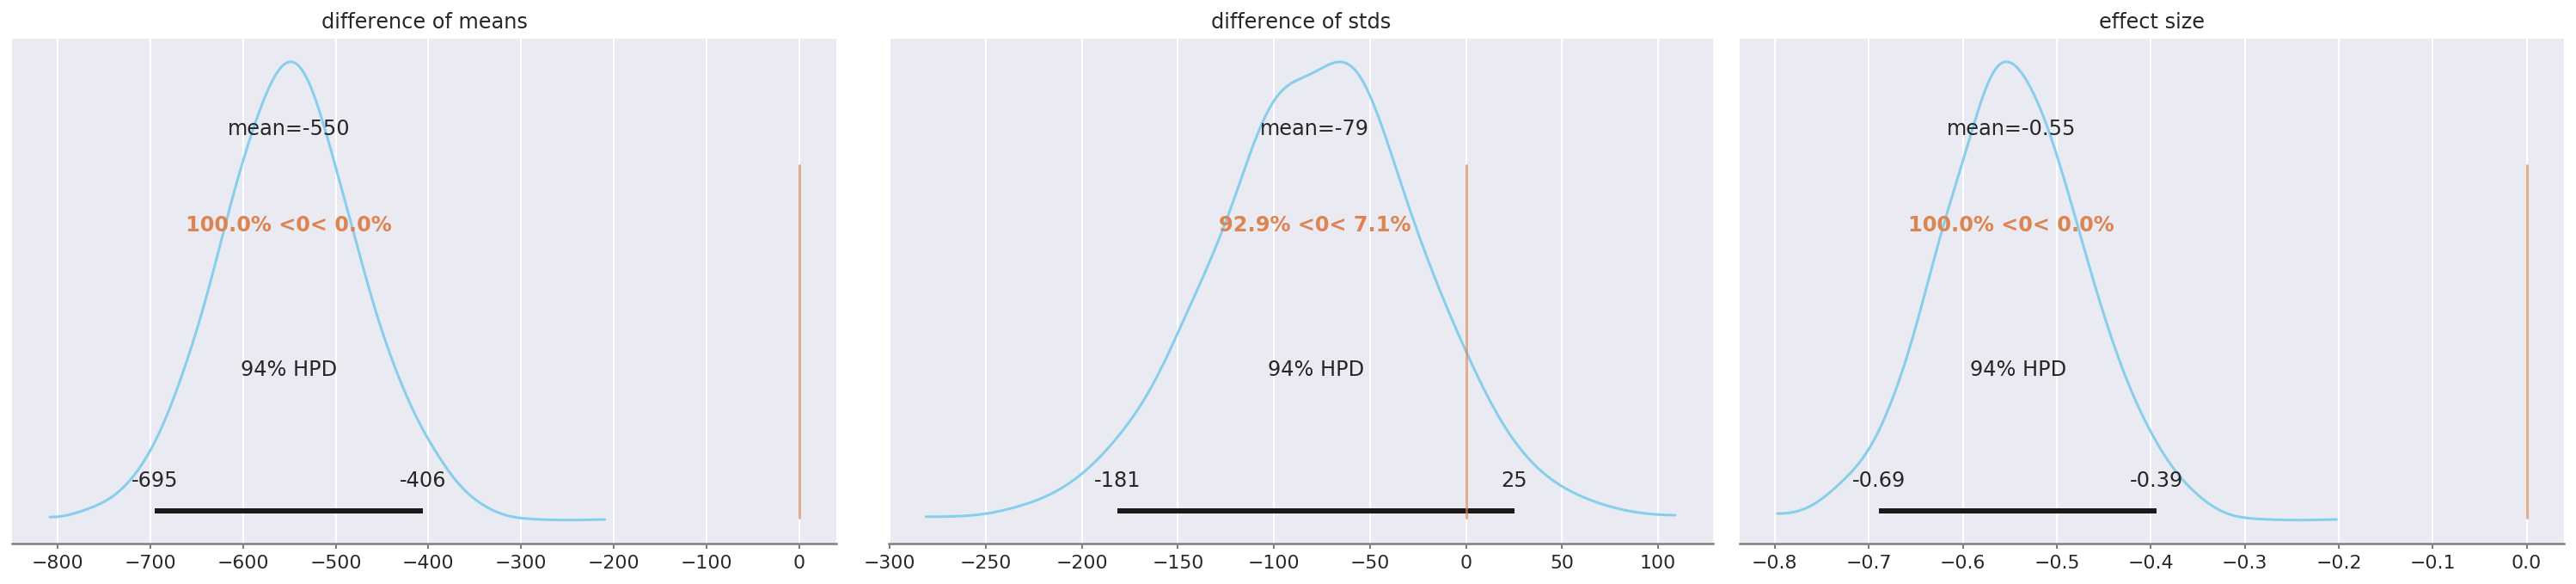

In [41]:
pm.plot_posterior(trace,
                  var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

#### Nota

Pueden lanzarse más de una cadena de forma paralela si hubiéramos utilizado la orden 

```python 
with model:
    trace = pm.sample(2000, njobs=2) #Number of parallel jobs to start. If None, set to number of cpus in the system.
```

En ese caso, podríamos haber utilizado la función ```forestplot``` que pinta los intervalos plausibles revelando evidencia de la falta de convergencia: valores cercanos a uno, tal y como aparecen aquí, sugieren que el mdoelo ha convergido.

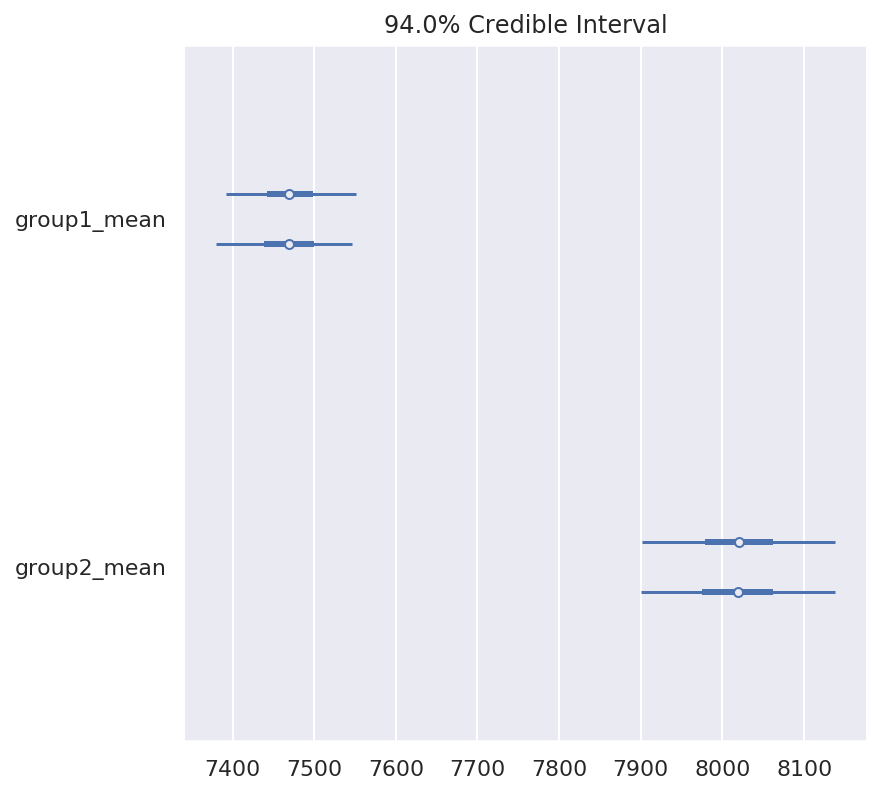

In [42]:
pm.forestplot(trace, var_names=['group1_mean',
                               'group2_mean']);

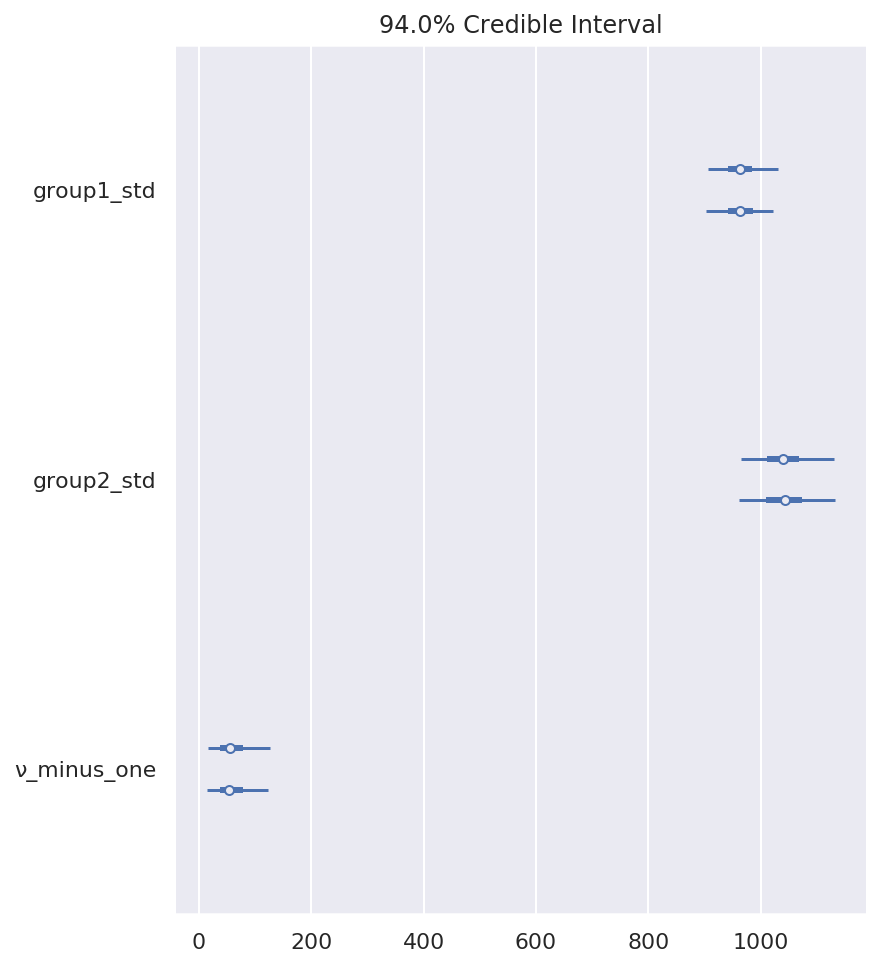

In [43]:
pm.forestplot(trace, var_names=['group1_std',
                               'group2_std',
                               'ν_minus_one']);

### Ejercicio con datos reales

Vamos a relizar el ejemplo (ficticio) explicado en el artículo 

http://psycnet.apa.org/record/2012-18082-001

Existen más recursos en la página web del autor:

https://cran.r-project.org/web/packages/BEST/vignettes/BEST.pdf

https://www.indiana.edu/~kruschke/


El ejemplo se basa en un ensayo clínico para evaluar la eficiencia de un nuevo medicamento que mejora el _Cociente Intelectual_ de las personas. Para ello se han tomado a 47 individuos a los que se les aplicará el tratamiento y 42 personas que harán de grupo control (se les administrará un placebo).

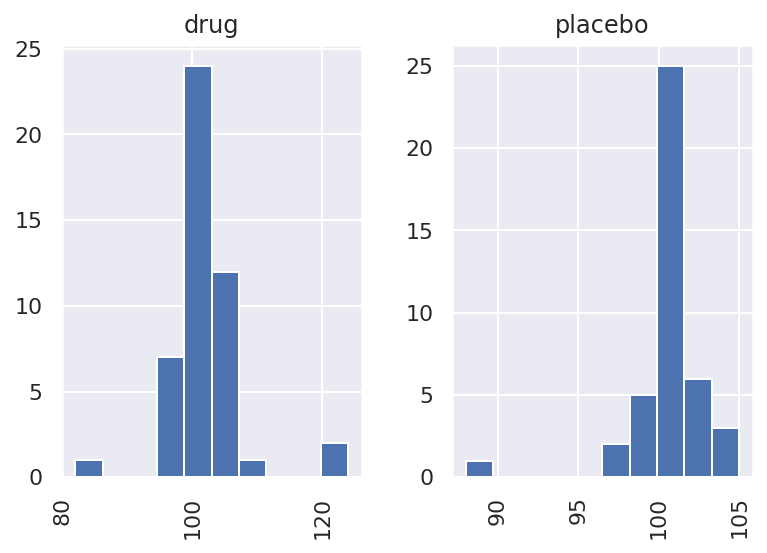

In [31]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)


y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group');